## Basic classifier that uses Distilbert model to predict whether supplied URL is malicious
##### Distilbert is a smaller and faster version of BERT ( Bidirectional Encoder Representations from Transformers) that is 40% lighter while retaining 97% of BERT's language understanding ability. More on Distilbert at [HuggingFace](https://huggingface.co/docs/transformers/model_doc/distilbert)

### To begin, let's install and import some packages


In [2]:
!pip3 install scikit-learn>=1.0.0
!pip3 install ktrain matplotlib tensorflow numpy
import matplotlib
import os
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

  Using cached ktrain-0.31.2-py3-none-any.whl (25.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.7 MB/s eta 0:00:0000:0100:01
  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py) ... done
  Using cached Whoosh-2.7.4-py2.py3-none-any.whl (468 kB)
  Using cached fastprogress-1.0.2-py3-none-any.whl (12 kB)
  Using cached transformers-4.10.3-py3-none-any.whl (2.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 3.8 MB/s eta 0:00:00a 0:00:01
  Using cached keras-bert-0.89.0.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 40.5 MB/s eta 0:00:0000:0100:01
  Using cached syntok-1.3.3-py3-none-any.whl (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00:00:01
  Using cached jieba-0.42.1.tar.gz (19.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.8 MB/s eta 0:00:00:00:01
  Using

#### Some more imports...We are using ktrain wrapper to simplify model operations and take advantage of some cool stuff like simplified data set preprocessing, learning rate finding and "autofit" that ensures the model is not overfit. More details on ktrain here: [ktrain on GitHub](https://github.com/amaiya/ktrain)

In [3]:
import ktrain
from ktrain import text

#### Let's print the list of available text classifiers in ktrain. There are relatively simple models like fasttext or bigru that have only 7-10 layers, as well as some more sophisticated deep models like BERT

In [8]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


### Here, we will load our data set. 
##### We have a CSV file ``trainlist_22k.csv`` that contains a list of HTTP paths that are labeled according to their association with cross-site scripting (xss) and sql injection (sqli).  There is also a "regular" traffic that belongs to a "benign" class. Data set load is performed using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.
##### In our set we have: 1 feature (payload), 1 label (type) that contains 3 classes:
 - xss
 - sqli
 - benign

##### We will be using Distilbert model so preprocessing mode is set to ``Distilbert``

In [4]:
DATA_PATH = 'urlData.csv'
NUM_WORDS = 5000
MAXLEN = 200
trn, val, preproc = text.texts_from_csv(DATA_PATH,
                      'url',
                      label_columns = ["label"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1,
                      preprocess_mode='distilbert')

detected encoding: utf-8 (if wrong, set manually)
['bad', 'good']
        bad  good
291500  0.0   1.0
354739  0.0   1.0
364516  0.0   1.0
217730  0.0   1.0
234278  0.0   1.0
['bad', 'good']
        bad  good
22346   1.0   0.0
146769  0.0   1.0
13610   1.0   0.0
259838  0.0   1.0
324172  0.0   1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


### Let's load the learner instance that uses ```Distilbert``` model. We will retain the model structure unchanged

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def get_model():
    model = text.text_classifier('distilbert', (trn), 
                             preproc=preproc)
    #model.add(Dense(3, activation='sigmoid'))
    #model.add(GaussianDropout1D(0.2))
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
distilbert_model = get_model()
#new_model = Sequential()
#new_model.add(nbsvm_model)
#new_model.add(Dense(2, activation='sigmoid'))
#new_model.add(Dropout(0.2))
#new_model.add(Dense(2, activation='relu'))
distilbert_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
learner = ktrain.get_learner(distilbert_model, train_data=(trn), val_data=(val))

Is Multi-Label? False
maxlen is 200
done.


#### Here is what our model looks like. It has a number of layers that are pre-trained therefore allowing us to leverage transfer learning.
##### Source code for modeling_tf_distilbert can be found at [HuggingFace Transformers](https://huggingface.co/transformers/v2.3.0/_modules/transformers/modeling_tf_distilbert.html)

In [6]:
learner.print_layers()


0 (trainable=True) : <transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertMainLayer object at 0x7f924b87c9d0>
1 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f924b8317d0>
2 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f924b831450>
3 (trainable=True) : <keras.layers.regularization.dropout.Dropout object at 0x7f924b831490>


#### We need to ensure that majority of existing pre-trained layers are not re-trained so we are freezing those with the following command:

In [7]:
learner.freeze(1)

#### The optimal learning rate for this model can be found using the **lr_find** function however it will take at least **20 minutes!** on this VM that uses CPU only. ( Optimal rate was found to be 3e-5 and therefore there is no need to spend time on this now). **If you still want to proceed**, uncomment the command and run the cell below

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
11826/11826 [==============================] - 38s 3ms/step - loss: 7.6692 - accuracy: 0.1826
Epoch 2/5
11826/11826 [==============================] - 37s 3ms/step - loss: 7.6538 - accuracy: 0.1834
Epoch 3/5
11826/11826 [==============================] - 37s 3ms/step - loss: 2.3351 - accuracy: 0.6713
Epoch 4/5
11826/11826 [==============================] - 21s 2ms/step - loss: 1.1553 - accuracy: 0.8468


done.
Visually inspect loss plot and select learning rate associated with falling loss


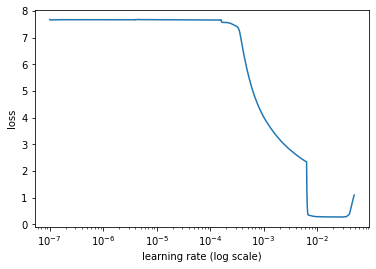

In [15]:
learner.lr_find(show_plot=True, max_epochs=5)

### Now let's train the model using the optimal learning rate. More accuracy is achieved after 4-5 epochs however to save time, we will run the cycle using 2 epochs only. That should give us ~93% accuracy and observed loss (binary crossentropy) of ~0.09

In [ ]:
learner.fit_onecycle(3e-5, 2)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/2
11826/11826 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8573

##### Autofit function can help optimally train the model without ``overfitting`` it. **Do not run** unless you are willing to spend days (or perhaps weeks) on training

In [16]:
learner.autofit(1e-2)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
11826/11826 [==============================] - 45s 4ms/step - loss: 0.5969 - accuracy: 0.8907 - val_loss: 0.1713 - val_accuracy: 0.9548
Epoch 2/1024
11826/11826 [==============================] - 45s 4ms/step - loss: 0.1974 - accuracy: 0.9518 - val_loss: 0.1618 - val_accuracy: 0.9552
Epoch 3/1024
11826/11826 [==============================] - 45s 4ms/step - loss: 0.1921 - accuracy: 0.9546 - val_loss: 0.1935 - val_accuracy: 0.9553
Epoch 4/1024
11826/11826 [==============================] - 45s 4ms/step - loss: 0.1965 - accuracy: 0.9539 - val_loss: 0.1873 - val_accuracy: 0.9560

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
Epoch 5/1024
11826/11826 [==============================] - 45s 4ms/step - loss: 0.1762 - accuracy: 0.9560 - val_loss: 0.1850 - v

#### Alright, let's save our predictor so we can use it to perform inferences outside of the Jupyter notebook

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('url_checker_distilbert')
print('MODEL SAVED')

### It's time for some fun! First, get a predictor instance that uses our pre-trained model

In [18]:
predictor = ktrain.load_predictor('url_checker_trained_2e')
new_model = ktrain.get_predictor(predictor.model, predictor.preproc)

#### Let's see if it can catch a malicious URL

In [30]:
text = 'yoris-parfums.com'
result = new_model.predict(text)
print(result)

[('bad', 0.28830546), ('good', 0.7625915)]


#### Now we can run more serious testing outside of the notebook